In [ ]:
%cd ..

%config InlineBackend.figure_format = "retina"

/home/marco/thesis_project/contrast-gan-3D


In [ ]:
# TODO check that evaluated scans do not contain outliers that shift the whole distribution

In [ ]:
from collections import defaultdict
from pathlib import Path
from pprint import pprint

import numpy as np
from batchgenerators.utilities.file_and_folder_operations import load_pickle
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

from contrast_gan_3D import config as project
from contrast_gan_3D.alias import ScanType
from contrast_gan_3D.data import utils as data_u
from contrast_gan_3D.eval import HU_distribution_shift as HU_ds
from contrast_gan_3D.eval import utils as eval_u
from contrast_gan_3D.eval.CCTAContrastCorrector import CCTAContrastCorrector

# from contrast_gan_3D.experiments.conf_2D import train_patch_size as inference_patch_size
from contrast_gan_3D.experiments.small_patch_size import (
    train_patch_size as inference_patch_size,
)
from contrast_gan_3D.trainer.utils import divide_scans_in_fold
from contrast_gan_3D.utils import io_utils, set_GPU
from contrast_gan_3D.utils import visualization as viz

DEVICE = set_GPU(5)
RUN_ID = "r3jqsob7"
RUN_NAME = "3D-WC-small-rmsprop"
ITER_CHECKPOINT = 8000
# RUN_NAME = "2D-WC-baseline"
# RUN_ID = "g5gqrbqo"
# ITER_CHECKPOINT = 6000


MODEL_CHECKPOINT = project.CHECKPOINTS_DIR / RUN_ID / f"{ITER_CHECKPOINT}.pt"
print(MODEL_CHECKPOINT)
assert MODEL_CHECKPOINT.is_file()


# NOTE set to None to avoid exporting corrected scans
ITK_EXPORT_DIR = project.CORRECTIONS_DIR / RUN_NAME
print(ITK_EXPORT_DIR)
ITK_EXPORT_DIR.mkdir(exist_ok=True, parents=True)


splits = load_pickle(project.DEFAULT_CVAL_SPLITS_PATH)
# trained on first fold, so use first test fold for evaluation
train_fold, val_fold = splits["train"][0], splits["test"][0]
for p, l in val_fold:
    print(p, ScanType(l))
subopt_patients = [
    (p, l)
    for (p, l) in val_fold
    if (sl := ScanType(l)) in [ScanType.HIGH, ScanType.LOW]
]
print(len(subopt_patients))


ASSETS_SAVEPATH = project.ASSETS_DIR / "evaluation" / RUN_NAME
ASSETS_SAVEPATH.parent.mkdir(exist_ok=True, parents=True)

for t, l in splits.items():
    print(t)
    for i, d in enumerate(l):
        pprint({ScanType(k): len(v) for k, v in divide_scans_in_fold(d).items()})

[2024-07-05 12:57:30,030: INFO] Subtract 238 to 0-center scans (contrast_gan_3D.data.Scaler:28)
/home/marco/thesis_project/contrast-gan-3D/logs/model_checkpoints/r3jqsob7/8000.pt
/home/marco/data/corrections/3D-WC-small-rmsprop
/home/marco/data/preproc/ASOCA_Philips/ASOCA-001 ScanType.OPT
/home/marco/data/preproc/ASOCA_Philips/ASOCA-002 ScanType.HIGH
/home/marco/data/preproc/ASOCA_Philips/ASOCA-003 ScanType.HIGH
/home/marco/data/preproc/ASOCA_Philips/ASOCA-004 ScanType.HIGH
/home/marco/data/preproc/ASOCA_Philips/ASOCA-005 ScanType.OPT
/home/marco/data/preproc/ASOCA_Philips/ASOCA-006 ScanType.HIGH
/home/marco/data/preproc/ASOCA_Philips/ASOCA-007 ScanType.OPT
/home/marco/data/preproc/ASOCA_Philips/ASOCA-013 ScanType.HIGH
/home/marco/data/preproc/ASOCA_Philips/ASOCA-016 ScanType.HIGH
/home/marco/data/preproc/ASOCA_Philips/ASOCA-018 ScanType.OPT
/home/marco/data/preproc/ASOCA_Philips/ASOCA-020 ScanType.OPT
/home/marco/data/preproc/ASOCA_Philips/ASOCA-025 ScanType.OPT
/home/marco/data/prepr

In [ ]:
################# plot myocardium segmentations #################

if False:
    DATASET_NAME = "ASOCA_Philips"

    DATASET = project.PREPROC_DATA_DIR / DATASET_NAME

    MASK_PATHS = project.SEGMENTATIONS_DIR / DATASET_NAME
    MASK_PATHS = sorted(list(MASK_PATHS.glob("*.mhd")))


    savefolder = project.ASSETS_DIR / "myocardium_seg"
    savefolder.mkdir(exist_ok=True, parents=True)

    if True:
        for mask_path in tqdm(MASK_PATHS):
            mask_name = io_utils.stem(mask_path)
            scan_path = DATASET / mask_name
            if mask_path.is_symlink():
                mask_path = mask_path.readlink()

            print(mask_path)
            seg, seg_meta = io_utils.load_sitk_image(mask_path, segmentation=True)
            scan, scan_meta = data_u.load_patient(scan_path)
            scan = scan[..., 0]
            # scan, scan_meta = io_utils.load_sitk_image("/home/marco/data/ASOCA_Philips/images/ASOCA-000.mhd")

            suffix = ""
            overlay = np.ma.masked_array(scan, seg)
            viz.plot_mid_slice(overlay)

            # NOTE runs slower but better visualization

            # suffix = "_all"
            # fig = viz.plot_axial_slices(
            #     scan[None, ..., ::7],
            #     value_range=(VMIN, VMAX),
            #     normalize=True,
            #     figsize=(15, 15),
            #     tight=False,
            # )
            # overlay = np.zeros((*scan.shape, 4))
            # overlay[seg == 1] = [1, 0, 0, 0.5]
            # overlay = overlay.transpose(3, 0, 1, 2)
            # viz.plot_axial_slices(overlay[..., ::7], fig=fig, tight=True)

            plt.tight_layout()
            plt.savefig(savefolder / f"{mask_name}{suffix}.png")
            plt.close()

In [ ]:
DEVICE = set_GPU(7)

scans_missing_corrections = [
    p for p, _ in subopt_patients if not (ITK_EXPORT_DIR / f"{io_utils.stem(p)}.mhd").is_file()
]
print(len(subopt_patients), len(scans_missing_corrections))

if len(scans_missing_corrections):
    corrector = CCTAContrastCorrector.from_checkpoint(
        inference_patch_size, DEVICE, MODEL_CHECKPOINT
    )
    eval_u.parallel_correct_patients(
        corrector, ITK_EXPORT_DIR, scans_missing_corrections, processes=2
    )

17 0


In [ ]:
def construct_patient_name(patient: str | Path):
    patient = str(patient)
    dataset_name, name = patient.split("/")[-2:]
    dataset, ext = dataset_name, "mhd"
    if "ASOCA" in dataset_name:
        dataset = "/".join([dataset_name, "images"])
    if "MMWHS" in dataset_name:
        dataset = "/".join([dataset_name, "_".join(name.split("_")[:2])])
        ext = "nii.gz"
    return Path(project.DATA_DIR / dataset / f"{name}.{ext}"), dataset_name, name


scans_for_HU_shift = defaultdict(list)

for patient, lab in val_fold:
    patient, dataset_name, name = construct_patient_name(patient)

    ctl_path = project.CENTERLINES_DIR / dataset_name / name
    seg_path = project.SEGMENTATIONS_DIR / dataset_name / f"{name}.mhd"

    scans_for_HU_shift["original"].append(((patient, ctl_path, seg_path), lab))
    if ScanType(lab) in {ScanType.LOW, ScanType.HIGH}:
        scans_for_HU_shift["corrected"].append(
            (
                (
                    project.CORRECTIONS_DIR / RUN_NAME / f"{name}.mhd",
                    ctl_path,
                    seg_path,
                ),
                lab,
            )
        )
scans_for_HU_shift = dict(scans_for_HU_shift)

pprint(scans_for_HU_shift)

for k, v in scans_for_HU_shift.items():
    print(k, len(v))

{'corrected': [((PosixPath('/home/marco/data/corrections/3D-WC-small-rmsprop/ASOCA-002.mhd'),
                 PosixPath('/home/marco/data/auto_centerlines/ASOCA_Philips/ASOCA-002'),
                 PosixPath('/home/marco/data/segmentation/ASOCA_Philips/ASOCA-002.mhd')),
                1),
               ((PosixPath('/home/marco/data/corrections/3D-WC-small-rmsprop/ASOCA-003.mhd'),
                 PosixPath('/home/marco/data/auto_centerlines/ASOCA_Philips/ASOCA-003'),
                 PosixPath('/home/marco/data/segmentation/ASOCA_Philips/ASOCA-003.mhd')),
                1),
               ((PosixPath('/home/marco/data/corrections/3D-WC-small-rmsprop/ASOCA-004.mhd'),
                 PosixPath('/home/marco/data/auto_centerlines/ASOCA_Philips/ASOCA-004'),
                 PosixPath('/home/marco/data/segmentation/ASOCA_Philips/ASOCA-004.mhd')),
                1),
               ((PosixPath('/home/marco/data/corrections/3D-WC-small-rmsprop/ASOCA-006.mhd'),
                 PosixPath(

In [ ]:
hus = {k: HU_ds.collect_voxels_intensity(v) for k, v in scans_for_HU_shift.items()}

Scans distribution by label:
{<ScanType.OPT: 0>: 23, <ScanType.LOW: -1>: 3, <ScanType.HIGH: 1>: 14}
ScanType.OPT
	Total voxels 'centerlines': 87749
	Total voxels 'ostia': 46
	Total voxels 'myocardium': 20697612
ScanType.HIGH
	Total voxels 'centerlines': 60186
	Total voxels 'ostia': 28
	Total voxels 'myocardium': 14300490
ScanType.LOW
	Total voxels 'centerlines': 13337
	Total voxels 'ostia': 6
	Total voxels 'myocardium': 4733851
Scans distribution by label:
{<ScanType.LOW: -1>: 3, <ScanType.HIGH: 1>: 14}
ScanType.HIGH
	Total voxels 'centerlines': 60186
	Total voxels 'ostia': 28
	Total voxels 'myocardium': 14300490
ScanType.LOW
	Total voxels 'centerlines': 13337
	Total voxels 'ostia': 6
	Total voxels 'myocardium': 4733851


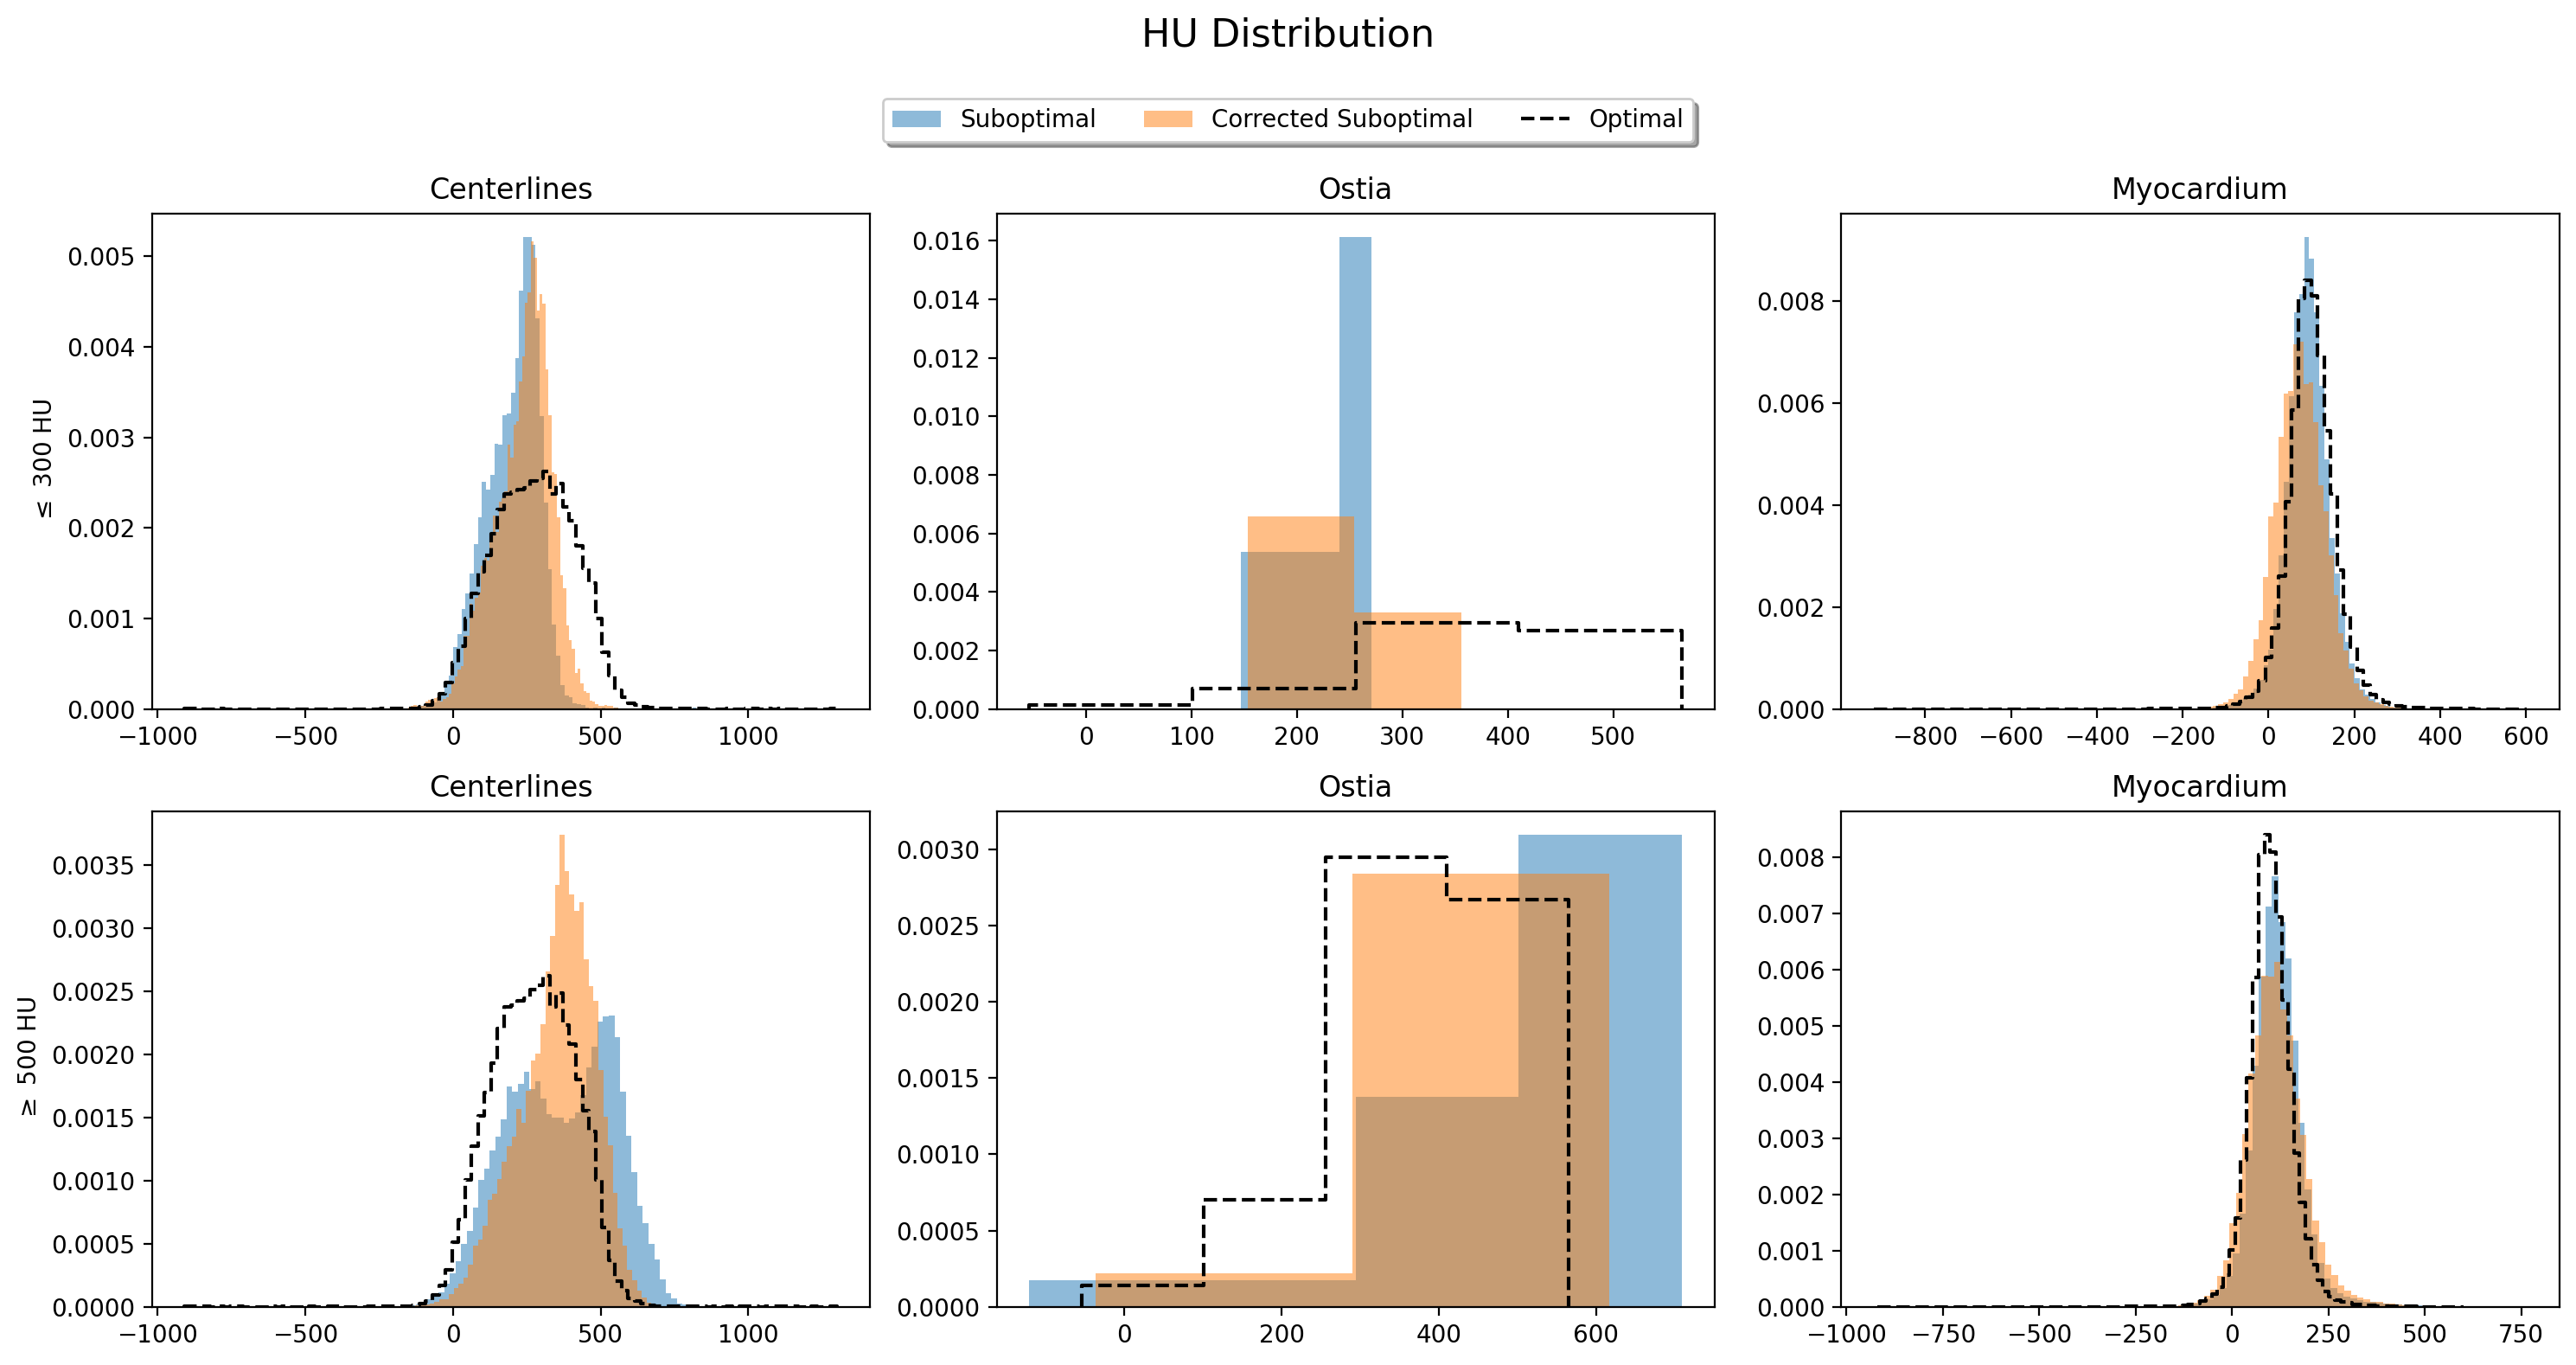

In [ ]:
viz.HU_distribution_shift_plot(hus["original"], hus["corrected"], None, True)